
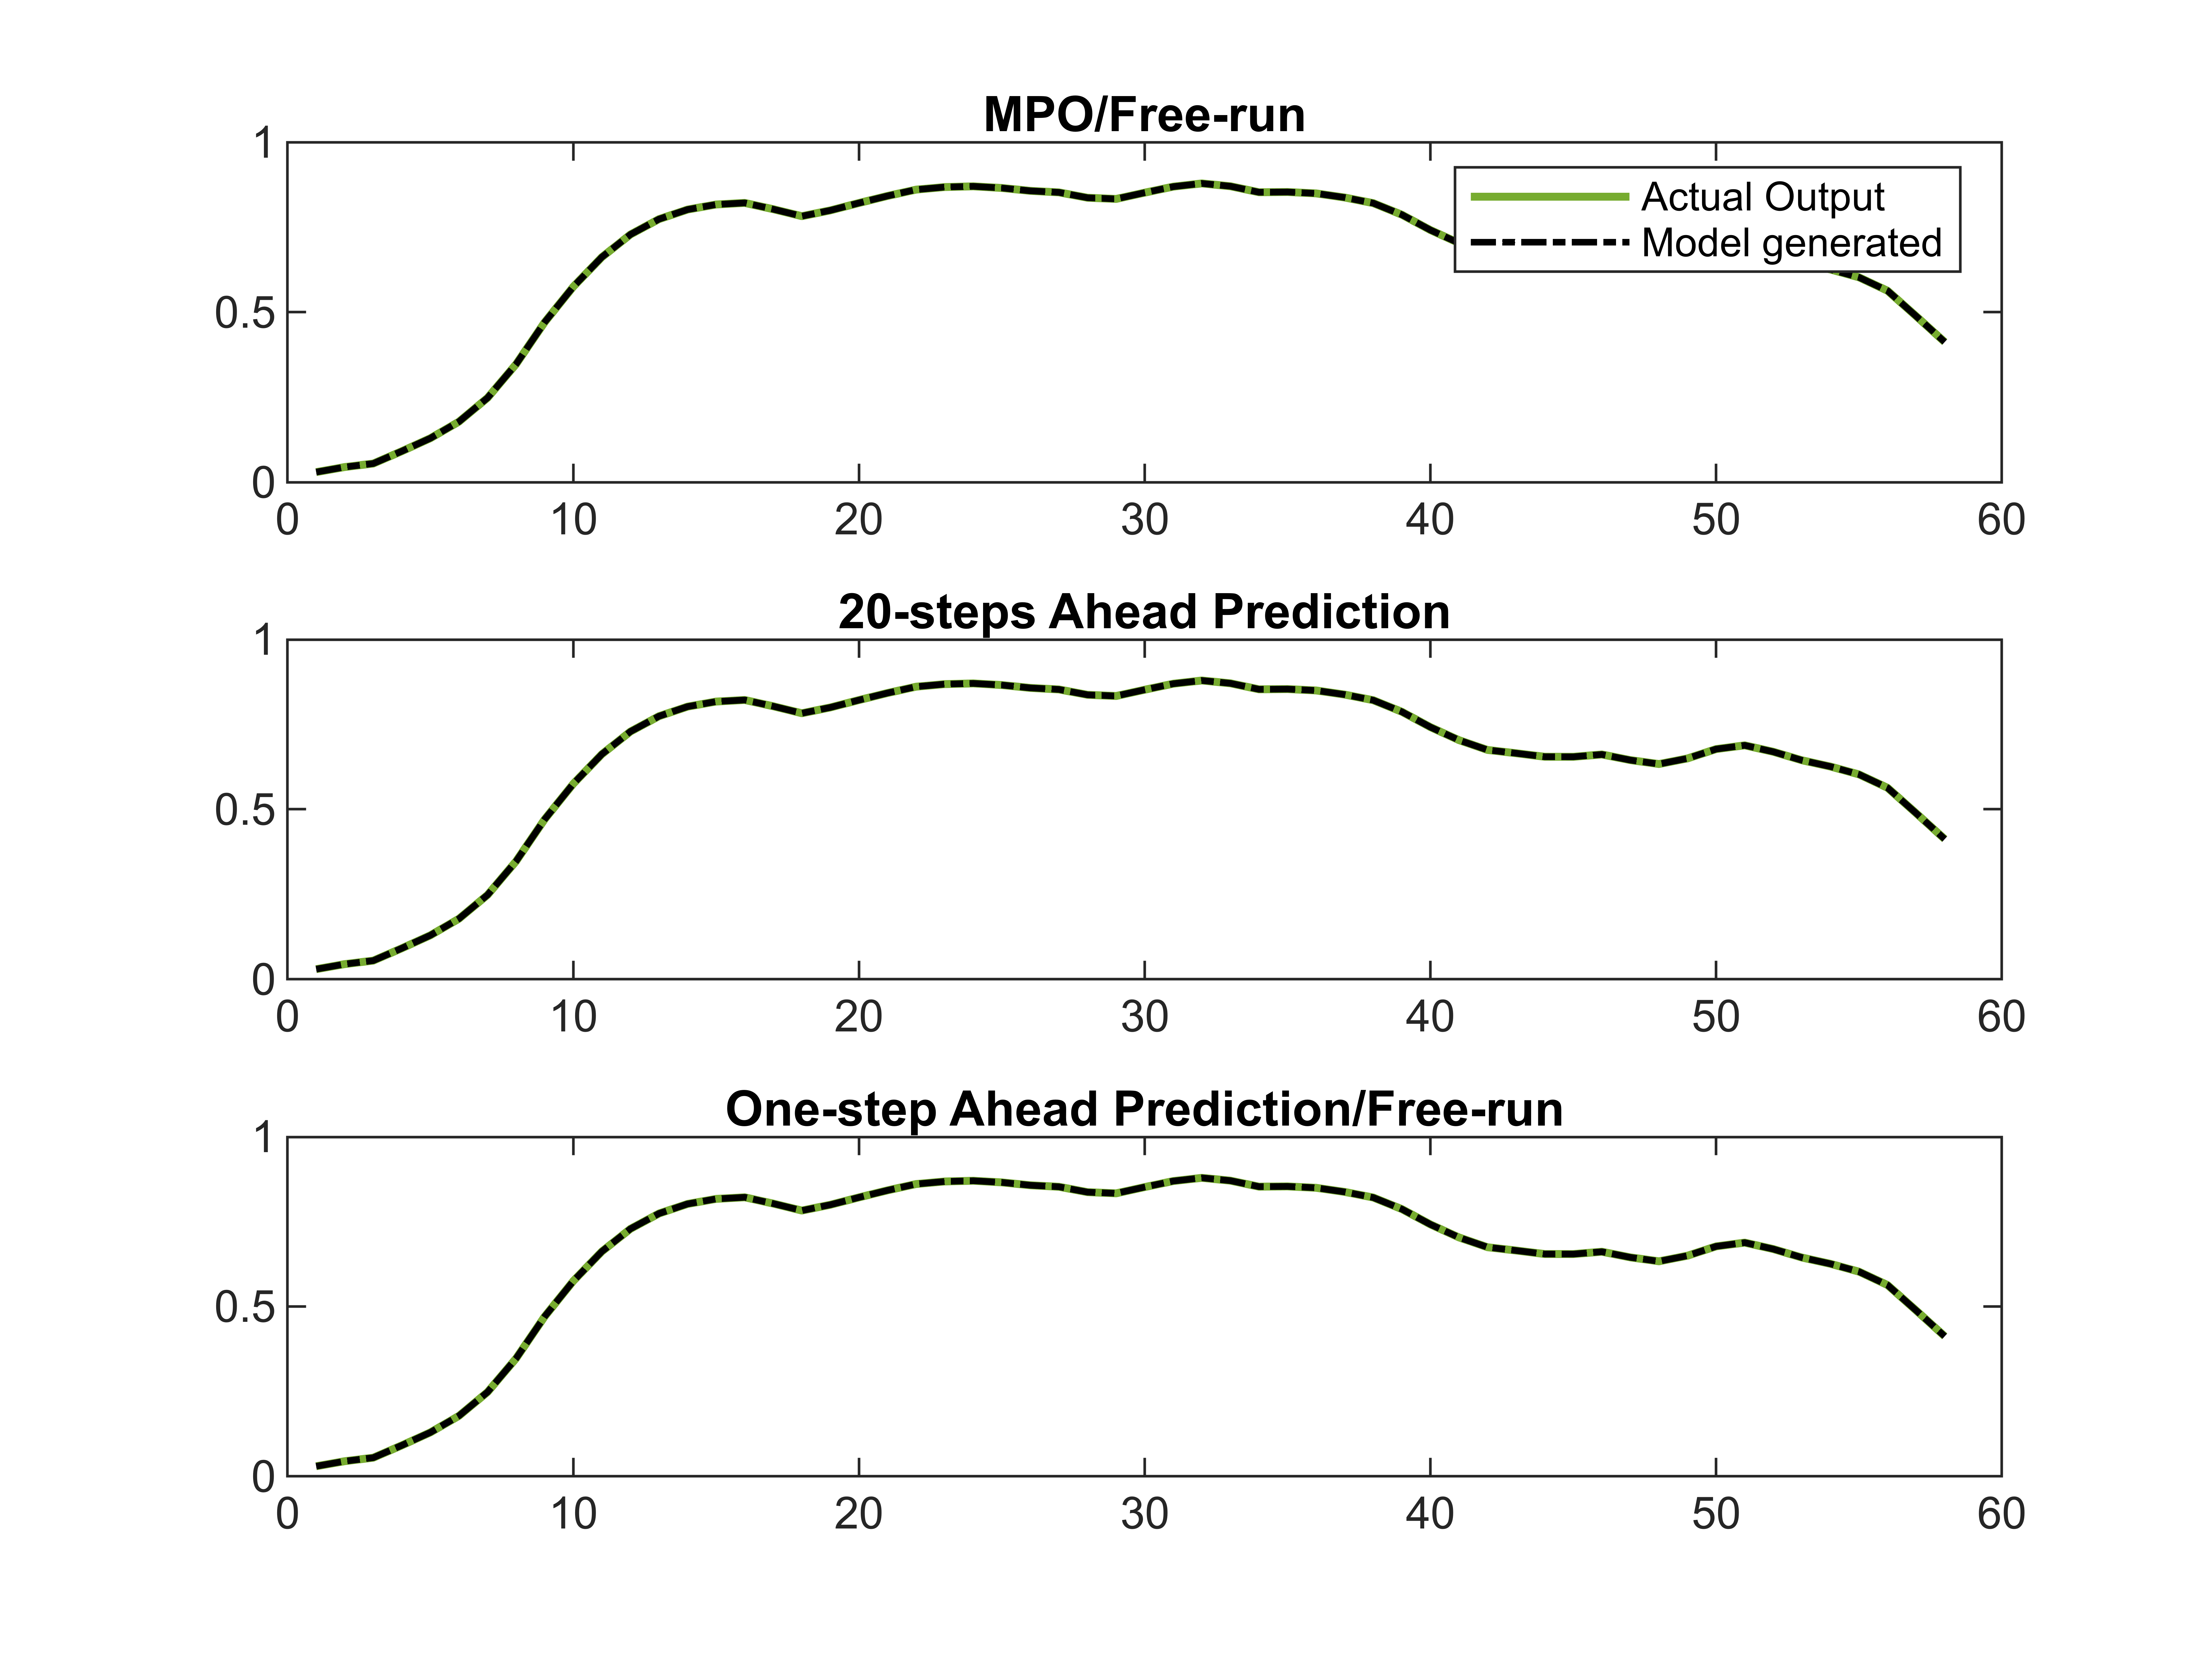

--------------------
MSSE = 5.8038e-28
MSkPE = 3.2225e-28
MSPE = 1.7432e-30
--------------------

In [1]:
close all;clear;clc
addpath('C:\Users\ae4159\OneDrive - Coventry University\PhD project\Matlab files\NonSysID');

%% Generate data from the system
% Simple MATLAB script to simulate the NARX model
%
$$y(t) = 1.7813y(t-1) - 0.7962y(t-2) + 0.0339u(t-1) + 0.0338u(t-2) - 0.1597y(t-1)u(t-1) - 0.1396y(t-1)u(t-2) + 0.1297y(t-2)u(t-1) + 0.1086y(t-2)u(t-2) + 0.0085y(t-2)^2$$

% Define the time series length and initialize input (u) and output (y) vectors
n = 1000; % Length of the data series
Ts = 1/800; tspan = 0:Ts:(n-1)*Ts;

e = 0 .* randn(n, 1); % Small noise term
rng(200); %Set the seed for th random number generator, to repeat the sequance generated.
u = randn(n, 1); % Random input signal
y = DC_motor_narx_model(n, u, e); % Simulate the NARX model
%% System Identification - NonSysID
tt_splt = 1:60; %Training samples of data
u_ID=u(tt_splt);
y_ID=y(tt_splt);

% Model type ARX/AR
mod_type = 'ARX';

% Maximum and minimum output lags
na1=1;na2=2;

% Maximum and minimum input lags
nb1=1;nb2=2;

% Maximum order of polynomial nonlinearity considered
nl_ord_max=2;

% Run more than one iteration of iOFR for [linear model ,nonlinear model]
x_iOFR = [false,false];

% Stoping criteria for [linear model ,nonlinear model]. PRESS_thresh/BIC_thresh
stp_cri = ['PRESS_thresh', 'PRESS_thresh'];
% Set value for stopping criteria for [linear model ,nonlinear model]
D1_thresh = [1e-4,10^(-4)];

% Specify if bias/DC off set is required, 0, or not, 1.
is_bias=0;

% Specify number of inputs
n_inpts=1;

% Specify the number of steps for k-steps ahead prediction
KSA_h=20;

% Specify which RCT (Reduce Computational Time) method to use, 1-4, 0 for
% no RCT.
RCT=0;

% Specify whether to simulate model and display results respectively
sim=[1,1];
% Set to 1 to display all models generated from iOFRs, 0 otherwise
displ=0;

% Run NonSysID
tic
[model, Mod_Val_dat, iOFR_table_lin, iOFR_table_nl, best_mod_ind_lin, best_mod_ind_nl, val_stats] = ...
    NonSysID(mod_type,u_ID,y_ID,na1,na2,nb1,nb2,nl_ord_max,is_bias,n_inpts,KSA_h,RCT,x_iOFR,stp_cri,D1_thresh,displ,sim);

In [2]:
toc

Elapsed time is 0.189964 seconds.

In [3]:

disp('ARX model:'); disp(iOFR_table_lin{best_mod_ind_lin,1});

ARX model:
                  ERR         theta  
               __________    ________
    y1(t-1)       0.93991      1.7542
    y1(t-2)     0.0016861    -0.76382
    u1(t-1)    0.00027304    0.012205
    u1(t-2)      0.058012    0.011004

In [4]:
if best_mod_ind_nl~=0
    disp('NARX model:');
    tbl_NARX = join(iOFR_table_nl{best_mod_ind_nl,10},iOFR_table_nl{best_mod_ind_nl,1});disp(tbl_NARX);
end

NARX model:
                      MS_PRESS_E     theta        ERR    
                      __________    _______    __________
    y1(t-1)             0.001342     1.7813       0.95001
    y1(t-2)           0.00016759    -0.7962      0.002255
    u1(t-1)              0.47871     0.0339      0.047434
    u1(t-2)           6.8123e-05     0.0338    0.00018925
    y1(t-1)u1(t-1)    2.2653e-05    -0.1597    3.6489e-05
    y1(t-1)u1(t-2)    6.1439e-05    -0.1396    1.9004e-05
    y1(t-2)y1(t-2)    3.1515e-30     0.0085    5.3837e-07
    y1(t-2)u1(t-1)    3.7241e-07     0.1297    2.9966e-05
    y1(t-2)u1(t-2)    4.6109e-05     0.1086    2.8901e-05


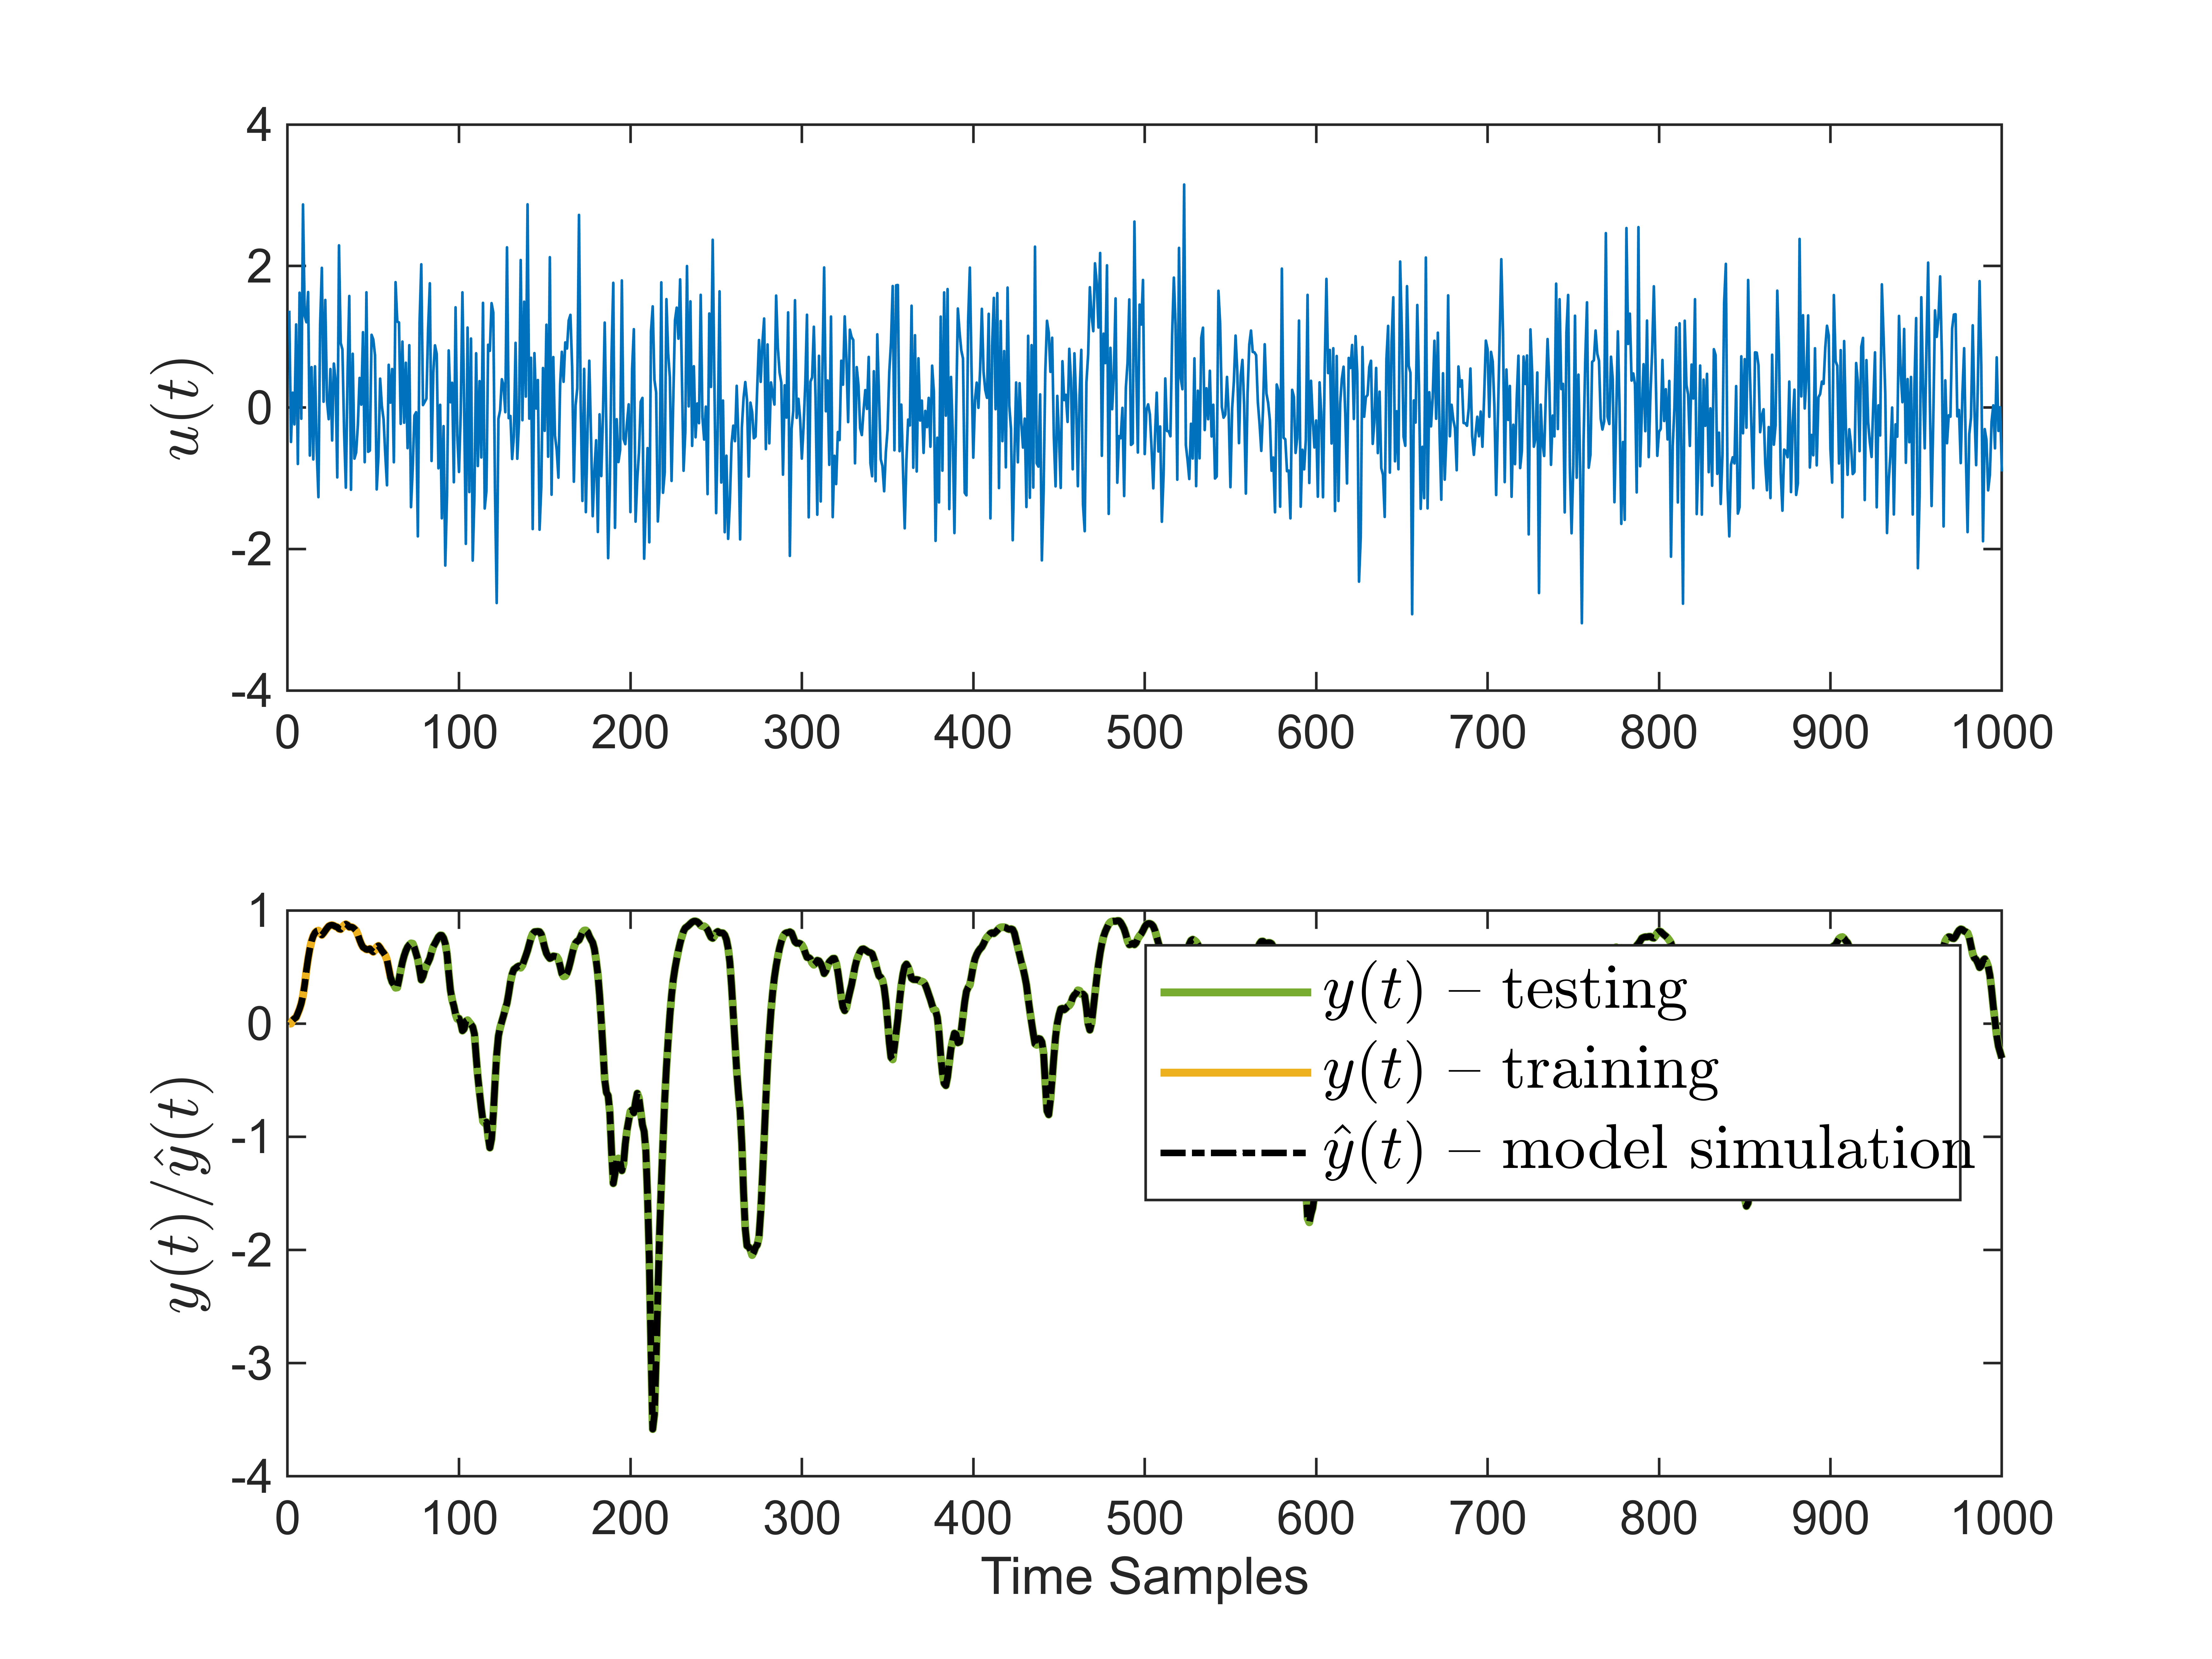

In [5]:
%% Simulate model and correlation based validation
[sse, y_hat, error, U_delay_mat_sim] = model_simulation(model,u,y,KSA_h);

%----------
figure;
subplot(2,1,1); plot(u, 'Color', '#0072BD');
ylabel(' !!!EQ_3!!! ','Interpreter','latex','FontSize',12);
%----------
n = length(y);
subplot(2,1,2);
plot(1:n, y,'Color', '#77AC30', 'LineWidth', 1.5); hold on;
plot(tt_splt, y_ID, 'Color', '#EDB120','LineWidth', 1.5); hold on;
plot((length(y)-length(y_hat)+1:n), y_hat(:,3), 'k-.', 'LineWidth',1.25);
legend(' !!!EQ_4!!!  -- testing', ' !!!EQ_4!!!  -- training',' !!!EQ_6!!!  -- model simulation','Interpreter','latex','FontSize',12);
xlabel('Time Samples');
ylabel(' !!!EQ_7!!! ','Interpreter','latex','FontSize',12);

In [6]:
%----------

% Normalise error and input
% Specify which error to use
e_ct = error(tt_splt,1); % simulation, one-step ahead or k-steps ahead (1,2,3 respectively)
u_ct = U_delay_mat_sim(tt_splt,1);
u_ct = u_ct - mean(u_ct);
u_ct = u_ct ./ std(u_ct);
e_ct = e_ct - mean(e_ct);
e_ct = e_ct ./ std(e_ct);
% NARX validation
[dat,conf_inv] = ac_cc_model_valid_nl(e_ct,u_ct,length(tt_splt),1);

In [7]:

disp(['RMSE = ',num2str( sqrt(mean(error(:,1).^2)) )]);

RMSE = 4.2119e-13

In [8]:
disp(['Error variance = ',num2str( var(error(:,1)) )]);

Error variance = 1.6018e-25